# Homework 2 (HW2)
By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

- Homework release: Fri 17 Nov 2023	

- **Homework Due**: Fri 01 Dec 2023, 23:59	

- Grades released: Mon 11 Dec 2023	


---

## Some rules
1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.

2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)

3. Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.

4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation **(in markdown)**.

5. Back up any hypotheses and claims with data, since this is an important aspect of the course.

6. Please write all your comments in **English**, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. **If there are multiple notebooks present, we will not grade anything.**

7. We will **not run your notebook for you!** Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

8. In continuation to the previous point, interactive plots, such as those generated using the `plotly` package, should be strictly avoided!

9. Make sure to print results and/or dataframes that confirm you have properly addressed the task.


---

In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

## Context

After two years, the EPFL Baseball Club is broke. The new Dean transferred all funds to EPFL's new poster child: its super-competitive Pétanque club. After struggling so much to learn about baseball, you have unfortunately been laid off...

*(...) 1 month after, you manage to get another job (!) (...)*

Congratulations! You have just been hired as a data scientist at the Association for Computational Linguistics (ACL), a professional organization for people working on natural language processing. The ACL organizes several of the top conferences and workshops in the field of computational linguistics and natural language processing.
Your boss, Dr. Tiancheng, knows of your expertise in observational studies and asks you to investigate a question that’s been bothering everyone who has ever submitted a paper to a conference: should I spend time on writing rebuttals?



---

## Rebuttals, conferences, and getting your papers accepted

Rebuttals in ACL (Association for Computational Linguistics) conferences and in many other academic conferences are an important part of the peer-review process. They allow authors of submitted papers to respond to the reviews and comments provided by the reviewers before a final decision is made regarding the acceptance of the paper. Here's how the rebuttal process typically works in ACL conferences:

- Paper Submission: Authors submit their research papers to the ACL conference for review. These papers present novel research findings in computational linguistics, natural language processing, and related areas.
- Peer Review: The papers undergo a peer-review process after the initial submission. The program committee or reviewers are experts in the field who evaluate the papers based on their quality, significance, novelty, methodology, and other relevant criteria. They provide comments and scores for each paper.
- Rebuttal Period: After receiving the reviews, authors are given a specific period (usually around a week) to write a rebuttal. The rebuttal is a formal response to the reviewers' comments. It allows authors to clarify misunderstandings, address concerns, and provide additional information to support their paper's quality. 
- Final Review: After receiving the rebuttals, the reviewers may reconsider their initial assessments in light of the authors' responses. Reviewers may choose to maintain or adjust their reviews and scores based on the quality and effectiveness of the author's rebuttal.
- Final Decision: The program committee or conference organizers consider the initial reviews/scores, rebuttals, and revised reviews/scores to make a final decision on the acceptance of the papers. The decision can be acceptance, rejection, or conditional acceptance with a request for revisions.


---

## Data

- `tmp_id`: Unique identifier for each paper in the format "P{number}".
- `status`: Accept or Reject.
- `submission_type`: Short vs. Long (papers can have different lengths). We do not use this column in this homework. 
- `track`: Track to which the paper was submitted, broadly speaking, the "topic" of the paper.
- `scores_before`: Scores received before rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework. 
- `scores_after`: Scores received after rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework.
- `had_rebuttal`: True or False.


Note that: 
 - reviews are assigned numbers, e.g., "2";
 - papers can have different numbers of reviews;
 - review numbers are arbitrary, e.g., `P1` in the dataframe has two reviews numbered "2" and "3" (but no review "1").


## Task 1 (10 pts): Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

- You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
- When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

**1.1** Load the dataset containing ACL reviews into memory using pandas. 
- For each paper, create columns `overall_score_before_avg` and `overall_score_after_avg` containing the average (overall) scores before and after rebuttal.
- For each paper, create columns `overall_score_before_std` and `overall_score_after_std` containing the standard deviation of the overall scores before and after the rebuttal.
- Print the four newly created columns for paper `P17`.
- Print the resulting dataframe.

In [5]:
df = pd.read_json("acl18_v1_numerical_final.json")

# Loops through conditions
for period in ["before", "after"]:
    for func, desc in zip([np.mean, np.std], ["avg", "std"]):
        
        # applies custom function to overall score of each inner JSON
        extract_avg_score = lambda xs: func([x['scores']["overall_score"] for _, x in xs.items()])
                                            
        # gets overall score for each paper                 
        df["overall_score_{}_{}".format(period, desc)] = df["scores_{}".format(period)].apply(extract_avg_score)
        

df = df.set_index("tmp_id")

df.loc["P17", ["overall_score_before_avg", 
               "overall_score_after_avg",
               "overall_score_before_std", 
               "overall_score_after_std"]]

overall_score_before_avg    4.5
overall_score_after_avg     4.5
overall_score_before_std    0.5
overall_score_after_std     0.5
Name: P17, dtype: object

**1.2** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain two panels: 
- **Panel A**: The distribution of `overall_score_before_avg` for papers that were accepted and papers that were rejected.
- **Panel B**: The distribution of `overall_score_before_avg` for papers that had rebuttals vs. papers that did not.

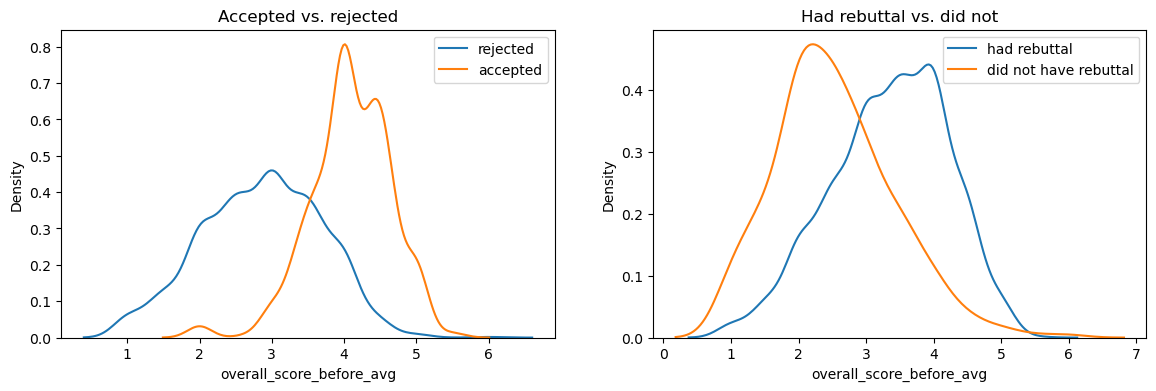

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14,4))

df["is_reject"] = df["status"] == "Reject"

# Panel A
sns.kdeplot(df[df["is_reject"]].overall_score_before_avg, label="rejected", ax=axs[0])
sns.kdeplot(df[~df["is_reject"]].overall_score_before_avg, label="accepted", ax=axs[0])
axs[0].legend()
axs[0].set_title("Accepted vs. rejected")

# Panel B
sns.kdeplot(df[df["had_rebuttal"]].overall_score_before_avg, label="had rebuttal", ax=axs[1])
sns.kdeplot(df[~df["had_rebuttal"]].overall_score_before_avg, label="did not have rebuttal", ax=axs[1])
axs[1].legend()
axs[1].set_title("Had rebuttal vs. did not");

**1.3** **/Discuss/:** If you know a paper had a rebuttal, is it more or less likely that it was accepted? Does this mean that rebuttals help papers get accepted? Explain why or why not, providing a concrete example.

**A:** 
-  Papers that get a rebuttal have higher score before rebuttal; there is a correlation between having a rebuttal and getting accepted.
- This does not mean that rebuttals "cause" acceptance, it could be that having rebuttals are correlated with other aspects (e.g., the pre-rebuttal score) that cause acceptance. 

**1.4** Print the percentage of rebuttals per track in the conference (defined by the `track` column). 

**/Discuss:/** Using "the logic" of hypothesis testing (see slide 29 of Lecture 4), how would you devise a statistical test to refute the following null hypothesis: all tracks have the same fraction of papers with rebuttals. Your statistical test should consider all categories at once, rather than comparing the fraction of rebuttals between pairs of categories.

In [7]:
df.groupby("track").had_rebuttal.mean()

track
Dialogue and Interactive Systems                                0.775281
Discourse and Pragmatics                                        0.804348
Document Analysis                                               0.730000
Generation                                                      0.779661
Information Extraction and Text Mining                          0.768362
Linguistic Theories Cognitive Modeling and Psycholinguistics    0.750000
Machine Learning                                                0.808696
Machine Translation                                             0.820755
Multidisciplinary and Area Chair COI                            0.680000
Multilinguality                                                 0.806452
Phonology Morphology and Word Segmentation                      0.851852
Question Answering                                              0.728395
Resources and Evaluation                                        0.732394
Sentence-level semantics                     

**A:** One could:

1. Generate a sample with %X rebuttals (here X could be the sample acceptance rate observed)
2. Randomly split that sample into "tracks," with sizes equal to that observed.
3. Calculate track-level rebuttal averages. Estimate the variance in % rebuttals across tracks under the null model.

Repeating this procedure, we could create an empirical distribution of variances under the null model. We could then use this to estimate whether some tracks have higher rebuttal rates.

**Obs: this is one possible answer, but other strategies are possible.**
    


## Task 2 (10pts): Prediction

You decide to investigate further the effect of rebuttals on acceptance using your machine learning skills.


**2.1** For each possible value in the `track` column, create a new column called {track}-onehot (e.g., for track=Generation, create Generation-onehot). Collectively, these new columns should "one hot-encode" the track column---for instance, if for a given paper the `track` column is filled with the value "Generation", the Generation-onehot column should equal 1 and all other {track}-onehot columns should equal 0. 

Print the column names of the resulting dataframe.

In [8]:
# create a one-hot encoding for the tracks and create a column Track-onehot for each track
df_oneh = pd.concat([df, pd.get_dummies(df["track"])], axis=1)

tracks = df_oneh["track"].unique()

# rename columns to <track>-onehot
df_oneh.columns = [col if col not in tracks else col + "-onehot" for col in df_oneh.columns]

# prints columns
[print(x) for x in df_oneh.columns];

status
submission_type
track
scores_before
scores_after
had_rebuttal
overall_score_before_avg
overall_score_before_std
overall_score_after_avg
overall_score_after_std
is_reject
Dialogue and Interactive Systems-onehot
Discourse and Pragmatics-onehot
Document Analysis-onehot
Generation-onehot
Information Extraction and Text Mining-onehot
Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot
Machine Learning-onehot
Machine Translation-onehot
Multidisciplinary and Area Chair COI-onehot
Multilinguality-onehot
Phonology Morphology and Word Segmentation-onehot
Question Answering-onehot
Resources and Evaluation-onehot
Sentence-level semantics-onehot
Sentiment Analysis and Argument Mining-onehot
Social Media-onehot
Summarization-onehot
Tagging Chunking Syntax and Parsing-onehot
Textual Inference and Other Areas of Semantics-onehot
Vision Robotics Multimodal Grounding and Speech-onehot
Word-level Semantics-onehot



**2.2** Create a column `had_rebuttal_int`, which equals 1 if the paper had a rebuttal, and 0 otherwise, and a column `accepted_int`, which equals 1 if the paper was accepted, and 0 otherwise. 

In [9]:
df_oneh["had_rebuttal_int"] = df_oneh["had_rebuttal"].astype(int)
df_oneh["accepted_int"] = (df_oneh["status"] == "Accept").astype(int)

**2.3** Create a function `numpy_helper(df, cols)` to obtain a numpy.array out of your dataframe. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension `(NxM)` cast as a float.

In [10]:
def numpy_helper(df, cols):
    """
    Transform given df with N rows and M columns to a numpy array of shape (N, M) cast as float32
    """
    return np.array(df[cols].values.tolist(), dtype=np.float32)


**2.4**
Create:
- an array of features X containing all track one-hot features, as well as the `overall_score_before_avg`,`overall_score_before_std`, and `had_rebuttal_int`;
- an array of outcomes y containing `accepted_int`. 


Print the shapes of both X and y (e.g., `X.shape`).

In [13]:
# defines rows
tracks_onehot = [track + "-onehot" for track in tracks]
restv = ["overall_score_before_avg", "overall_score_before_std", "had_rebuttal_int"]

# creates arrays
X = numpy_helper(df_oneh, tracks_onehot + restv)
y = numpy_helper(df_oneh, ["accepted_int"]).ravel()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1538, 24)
y shape: (1538,)



**2.5** Build two `GradientBoostingClassifier` models using `sklearn` using the default parameters:
- Model 1: predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std`.
- Model 2:  predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std` **and** `had_rebuttal_int`.


For both models:

- Use the `cross_validate` function from `sklearn.model_selection` to compute the average precision, recall, and accuracy across test cross validation splits.

    - e.g., `cross_validate(clf, X, y, cv=30, scoring=('accuracy', 'precision', 'recall'))`

In [14]:

# model 1
model1 = GradientBoostingClassifier()
cv_results1 = cross_validate(model1, X, y, cv=30, scoring=("accuracy", "precision", "recall"))
print(f"cv_results1: accuracy={cv_results1['test_accuracy'].mean()}, \
precision={cv_results1['test_precision'].mean()}, recall={cv_results1['test_recall'].mean()}")

# model 2
model2 = GradientBoostingClassifier()
cv_results2 = cross_validate(model2, X[:, :-1], y, cv=30, scoring=("accuracy", "precision", "recall"))
print(f"cv_results2: accuracy={cv_results2['test_accuracy'].mean()}, \
precision={cv_results2['test_precision'].mean()}, recall={cv_results2['test_recall'].mean()}")

cv_results1: accuracy=0.8386500754147814, precision=0.7126813001813002, recall=0.5957264957264959
cv_results2: accuracy=0.8373303167420816, precision=0.7085207385207386, recall=0.592948717948718



**2.6** Determine whether the difference in accuracy of the two models is statistically significant.


In [15]:
# use a ttest to determine if the difference in accuracy between the two models is significant
from scipy.stats import ttest_ind
ttest_ind(cv_results1["test_accuracy"], cv_results2["test_accuracy"])

TtestResult(statistic=0.1291661307585383, pvalue=0.897673080747567, df=58.0)

**A:** No significant difference



**2.7** **/Discuss:/** Contrast the results obtained in **2.6** with what you observed in **Task 1**. What advantage did the analyses in **2.6** have?

**A:** 

- In **Task 1** we saw that rebuttals was correlated with acceptance;
- Here, we found that rebuttals do not improve the prediction of our classifier;
- This latter analysis had the advantage that it incorporated the track and the scores prior to the rebuttal, which could also influence acceptance by themselves.


## Task 3 (12pts): Interlude



**3.1** Using the formula API from `statsmodels`, estimate the following linear regressions. Report the summary of the models.
- `accepted_int ~ had_rebuttal_int`,  
- `accepted_int ~ overall_score_after_avg`
- `had_rebuttal_int ~ overall_score_before_avg`

In [16]:
model1 = smf.ols(formula='accepted_int ~ had_rebuttal_int', data=df_oneh)
model1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           accepted_int   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     66.22
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           8.24e-16
Time:                        12:02:34   Log-Likelihood:                -855.16
No. Observations:                1538   AIC:                             1714.
Df Residuals:                    1536   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0838      0.023      3.693      0.000       0.039       0.128
had_rebuttal_int     0.2098      0.026      8.138      0.000       0.159       0.260
==============================================================================
Omnibus:                      271.753   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.377
Skew:                           1.075   Prob(JB):                     3.65e-71
Kurtosis:                       2.336   Cond. No.                         4.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
model2 = smf.ols(formula='accepted_int ~ overall_score_after_avg', data=df_oneh)
model2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           accepted_int   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     1031.
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          1.58e-173
Time:                        12:02:34   Log-Likelihood:                -492.65
No. Observations:                1538   AIC:                             989.3
Df Residuals:                    1536   BIC:                             1000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.6558      0.029    -22.339      0.000      -0.713      -0.598
overall_score_after_avg     0.2860      0.009     32.111      0.000       0.269       0.303
==============================================================================
Omnibus:                      110.778   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.680
Skew:                           0.256   Prob(JB):                     5.99e-12
Kurtosis:                       2.263   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
model3 = smf.ols(formula='had_rebuttal_int ~ overall_score_before_avg', data=df_oneh)
model3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       had_rebuttal_int   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     240.2
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.89e-50
Time:                        12:02:35   Log-Likelihood:                -727.42
No. Observations:                1538   AIC:                             1459.
Df Residuals:                    1536   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2527      0.035      7.195      0.000       0.184       0.322
overall_score_before_avg     0.1651      0.011     15.499      0.000       0.144       0.186
==============================================================================
Omnibus:                      201.621   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              288.526
Skew:                          -1.060   Prob(JB):                     2.23e-63
Kurtosis:                       2.890   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


**3.2** **/Discuss:/** Interpret the coefficients associated with the binary independent variable in the above models. Note that independent variables are the ones on the right-handside of the equation.

- e.g., in `had_rebuttal_int ~ overall_score_before_avg`, `overall_score_before_avg` is the independent variable.



**A:** 

- The coefficients associated with the independent variables correspond to percentage point increases in the outcome.
- In the case of `overall_score_after_avg` and `overall_score_before_avg`, it corresponds to the percentage point increase associated with a 1 point increase in the independent variable.
- In the case of `had_rebuttal_int`, it corresponds to the percentage point increase associated with papers receiving rebuttals.


**3.3** **/Discuss:/** describe three correlations you can draw from the previous analysis. Describe their sign (i.e., whether they are positive or negative), and whether they are statistically significant (at the .05 level of significance).


**A:** 
- Correlation 1 (`accepted ~ had_rebuttal`): positive and statistically significant
- Correlation 2 (`accepted ~ overall_score_after_avg`): positive and statistically significant
- Correlation 3 (`had_rebuttal_int ~ overall_score_before_avg`): positive and statistically significant

**3.4** **/Discuss:/** Is the following statement True or False? Justify. 

- The variable `overall_score_after_avg` explains more of the variance in `accepted_int`than the variable `overall_score_before_avg` explains of `had_rebuttal_int`.


**A** 
True: The highest value of R^2 indicates a more powerful predictor for the outcome.
- accepted_int ~ overall_score_after_avg -> $R^2$ = 0.40
- had_rebuttal_int ~ overall_score_before_avg -> $R^2$ = 0.13


**3.5** **/Discuss:/** Create a causal diagram relating the following variables:
- "Sa": `overall_score_after_avg`
- "Sb": `overall_score_before_avg`
- "Re": `had_rebuttal_int`
- "Ac": `accepted_int`
- "Tr": `track`


When unsure about whether a causal relationship exists, include it in the diagram. E.g., include the arrow corresponding to the key questions around this homework, i.e., `had_rebuttal_int`->`accepted_int`, even though you are investigating whether it exists. 

You may draw your diagram using text, use Sa/Sb/Re/Ac/Tr to represent the names of the variables, and simply indicate the causal links, one per line.


Instead of drawing something like this:
![](./dagv.jpeg)

Simply write:

- Tr->Sb
- Tr->Ac
- Tr->Re
- Ac->Sb
- Re->Sb
- Sb->Sa

---

**A:**

**Necessary:**
- Sb->Sa
- Sb->Re
- Sa->Ac
- Tr->Re
- Tr->Ac
- Re->Sa
- Re->Ac

**Optional:**
- Tr->Sb
- Tr->Sa
- Sb->Ac


**3.6** **/Discuss:/** What is the problem of simply comparing the outcomes of papers that had rebuttals with those that did not? Give a concrete example.

**A:** 
- Confounding. Common causes of both rebuttals and acceptance.
- For example, it could be that the track influences both rebuttal rates (because different subfields have different norms) and the acceptance rate. This could lead this naive analysis to reach an incorrect conclusion.

# Task 4 (12 pts): Observational study

You decide to use your observational study skills to obtain a concrete answer to the question: do rebuttals increase acceptance?

 **4.1** Perform exact one-to-one matching considering the `overall_score_before_avg` and the `track` variables. Each paper that had a rebuttal ("treatment group") should be matched to a paper that did not have a rebuttal ("control group"). 
- Your matching should be optimal, i.e., the maximum amount of papers possible must be matched. 
- Print the dataframe of papers in the matched sample

In [19]:
# split between control and treatment group
df_oneh = df_oneh.reset_index()
acl_had_rebuttal_df = df_oneh[df_oneh["had_rebuttal_int"] == 1]
acl_no_rebuttal_df = df_oneh[df_oneh["had_rebuttal_int"] == 0]

# create a graph of one-to-one matching
G = nx.Graph()

# do one-to-one matching between the two groups using exact matching on the following variables:
# score_before_avg and track
# note: since we loop starting with treatment group, it will match on lowest id
for acl_had_rebuttal_idx, acl_had_rebuttal_row in acl_had_rebuttal_df.iterrows():
    for acl_no_rebuttal_idx, acl_no_rebuttal_row in acl_no_rebuttal_df.iterrows():
        if acl_had_rebuttal_row["overall_score_before_avg"] == acl_no_rebuttal_row["overall_score_before_avg"]\
        and acl_had_rebuttal_row["track"] == acl_no_rebuttal_row["track"]:
            G.add_weighted_edges_from([(acl_had_rebuttal_row["tmp_id"], acl_no_rebuttal_row["tmp_id"], 1)])

# compute the maximum weight matching
matching = nx.max_weight_matching(G)

matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_acl_df = df_oneh[df_oneh["tmp_id"].isin(matched)]

balanced_acl_df

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,...,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot,had_rebuttal_int,accepted_int
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,0.500000,2.500000,...,False,False,False,False,False,False,False,False,1,0
11,P12,Reject,Long,Machine Translation,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.666667,0.471405,2.666667,...,False,False,False,False,False,False,False,False,0,0
14,P15,Reject,Long,Document Analysis,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.333333,0.471405,2.333333,...,False,False,False,False,False,False,False,False,0,0
19,P20,Reject,Long,Information Extraction and Text Mining,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,1.000000,0.000000,1.000000,...,False,False,False,False,False,False,False,False,1,0
35,P36,Reject,Long,Sentiment Analysis and Argument Mining,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.500000,0.500000,2.500000,...,False,True,False,False,False,False,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,P1540,Accept,Long,Generation,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.000000,0.000000,4.000000,...,False,False,False,False,False,False,False,False,1,1
1534,P1542,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,0.816497,2.000000,...,False,False,False,False,False,False,False,False,0,0
1535,P1543,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.666667,0.942809,2.666667,...,False,False,False,False,False,False,False,False,1,0
1536,P1544,Reject,Short,Social Media,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,0.000000,2.000000,...,False,False,True,False,False,False,False,False,0,0


**4.2** So far, we did not consider the `overall_score_before_std` variable. One could argue that the variance in the scores makes a difference. E.g., a paper that received scores 1 and 5, might be very different from a paper with scores 3 and 3. 

Note that you did not match on the `overall_score_before_std` variable. However, it suffices if this variable is "balanced" across treatment and control groups.
 Use the Standardized Mean Difference (SMD) to assess whether that's the case.

- The standardized mean difference for a variable $x$ and two groups $t$ and $c$ is defined as: $\frac{| E[x_t] - E[x_c] |}{\sqrt{Var[x_t] + Var[x_c]}}$

- Note that a Standardized Mean Difference smaller than 0.1 suggests that variables are balanced across treatment and control groups.


In [20]:
# compute SMD for overall_score_before_std

mean_std_treatment = balanced_acl_df[balanced_acl_df["had_rebuttal_int"] == 1]["overall_score_before_std"].mean()
mean_std_control = balanced_acl_df[balanced_acl_df["had_rebuttal_int"] == 0]["overall_score_before_std"].mean()

var_std_treatment = balanced_acl_df[balanced_acl_df["had_rebuttal_int"] == 1]["overall_score_before_std"].var()
var_std_control = balanced_acl_df[balanced_acl_df["had_rebuttal_int"] == 0]["overall_score_before_std"].var()

smd = (mean_std_treatment - mean_std_control) / np.sqrt((var_std_treatment + var_std_control) / 2)
smd

0.006945737087860334

**A**:  The `score_before_std` variable is balanced.


**4.3** Using the matched sample, estimate the following linear regression: `accepted ~ had_rebuttal_int`.


In [21]:
linreg_res = smf.ols(formula='accepted_int ~ had_rebuttal_int', data=balanced_acl_df).fit()
linreg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           accepted_int   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.132
Date:                Wed, 06 Dec 2023   Prob (F-statistic):              0.288
Time:                        12:02:43   Log-Likelihood:                -155.48
No. Observations:                 542   AIC:                             315.0
Df Residuals:                     540   BIC:                             323.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1033      0.020      5.266      0.000       0.065       0.142
had_rebuttal_int     0.0295      0.028      1.064      0.288      -0.025       0.084
==============================================================================
Omnibus:                      251.521   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              793.567
Skew:                           2.360   Prob(JB):                    4.78e-173
Kurtosis:                       6.587   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


**4.4** **/Discuss:/**

i. Considering your results obtained in 4.3, and the causal diagram drawn in Task 3: do rebuttals increase the chance of a paper getting accepted? Why are results different from what you obtained in **Task 1?**

ii. Why is there no need to include other covariates (e.g., score before) in the regression?

**A:**

i.
- Rebuttals do not seem to increase the chances of a paper getting accepted.
- After controlling for the track and the score before rebuttal with the matching, the causal effect vanishes. This is different from Task 1, where we did not take this confounders into account.

ii.
- Because these other covariates were manually balanced with the exact matching

**4.5** **/Discuss:/** Imagine there is another, unobserved variable "quality" which captures the true quality of the paper. Suppose quality ("Qu") is connected to the DAG you drew in the following ways:
- Qu -> Sa
- Qu -> Sb
- Qu -> Re
- Qu -> Ac


Assume that
- quality can only increase the chances of rebuttals;
- quality and the rebuttal can only increase the chance of a paper being accepted.
Does this uncontrolled confounder threaten the validity of your findings?


**A:**
- No it does not.
- Because, given the assumptions, this confounder could only increase the chance of acceptance for papers with rebuttals. We found that papers with rebuttals did not increase, so this confounder cannot be at play here (under the said assumptions)